In [167]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [168]:
from astropy.io import ascii 
import numpy as np
import math
from scipy.io import readsav
from scipy.interpolate import griddata
from scipy import interpolate
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import matplotlib as mpl
from matplotlib.font_manager import FontProperties
from astropy.table import Table,Column
from scipy.io import readsav
import os


def convert_to_correct_format(runname, planet_name,INITIAL_NTAU):
    def readfortfiles(path,runname,fort26,fort50,nlay,gasconst,oom,grav,tgr): 
        with open(path+runname+'/'+fort26) as f:
            first_line=f.readline()
            nlat,nlon,nlev=first_line.split()
            nlat,nlon,nlev=int(nlat),int(nlon),int(nlev)
        f.close()
        data26=np.empty([nlon*nlat*nlev, 6])
        
        l=0
        lp=0
        with open(path+runname+'/'+fort26) as f:
            for line in f:
                if l==0:
                    l+=1
                    continue
                elif l%2==1 and l<=nlon*nlat*nlev*2.:
                    line_pair=np.empty([6])
                    lon, lat, lev, u, v = line.split()
                    line_pair[:5] = np.float32(lon), np.float32(lat), int(lev), np.float32(u), np.float32(v)
                elif l%2==0 and l<=nlon*nlat*nlev*2.:
                    line_pair[5]=np.float32(line)
                    data26[lp,:]=line_pair
                    lp+=1
                elif l>nlon*nlat*nlev*2.:
                    #print ('       END OF FILE: DONE')
                    break
                l+=1
        f.close()

        lon_arr_f=data26[:,0]
        lon_arr=np.array([])
        for l in range(0,len(lon_arr_f)):
            el=lon_arr_f[l]
            if not el in lon_arr:
                lon_arr=np.append(lon_arr,el)

        lat_arr_f=data26[:,1]
        lat_arr=np.array([])
        for l in range(0,len(lat_arr_f)):
            el=lat_arr_f[l]
            if not el in lat_arr:
                lat_arr=np.append(lat_arr,el)

        lev_arr_f=data26[:,2]
        lev_arr=np.array([])
        for l in range(0,len(lev_arr_f)):
            el=lev_arr_f[l]
            if not el in lev_arr:
                lev_arr=np.append(lev_arr,el)

        data_26=np.empty([nlev,nlon,nlat,6])
        for l in range(0,data26.shape[0]):
            lon,lat,lev=data26[l,:3]
            lon_i,lat_i,lev_i=np.where(lon_arr==lon)[0][0],np.where(lat_arr==lat)[0][0],np.where(lev_arr==lev)[0][0]
            data_26[lev_i,lon_i,lat_i,:]=data26[l,:]

        nlev,nlon,nlat,nparam=data_26.shape
        temps=data_26[:,:,:,5]
        lats=data_26[0,0,:,1]
        #print(lats) starts at 87.5
        #lons=data_26[:,0,0,0]
            # nparam index: 
        #      0=lons
        #      1=lats
        #      2=levs
        #      3=u wind
        #      4=v wind
        #      5=temps
        
        #get surface pressures
        with open(path+runname+'/'+fort50,'r') as data_50:  #fort_50 long1 lat1 pressure 
            specificp=np.zeros((nlat,nlon))  #lat,long               #long1 lat2 pressure
            acount=0
            bcount=0
            next(data_50)
            for line in data_50:
                p=line.split()
                if bcount<nlat and acount<nlon:
                    specificp[bcount][acount]=((float(p[2]))+1)*surfp
                    bcount=bcount+1
                else:
                    if acount<nlon:
                        acount=acount+1
                        bcount=0
                        if acount<nlon:
                            specificp[bcount][acount]=((float(p[2]))+1)*surfp
                            bcount=bcount+1
                    
        #set sigma

        sigma=np.empty([nlay])*0.0
        if oom>0: #setting up pressure values 
            stp=-1.0*oom/nlay
            sigma[nlay-1]=10.**(stp/2.)
            for n in range(nlay-2,-1,-1):
                sigma[n]=sigma[n+1]*10.**(stp)
        p_BAR=sigma*surfp
        #print(len(p_BAR))
        #print(p_BAR)
        sp=specificp

        #create array to hold heights
        z=np.zeros((nlat,nlon,nlay,2))#one for z value, one for prssure
        #print (nlay)
        #set altitude of the first level (up from base=p0, where T=TGR) #matches idl
        z[:,:,nlay-1,0]=(gasconst/grav) *.5*(temps[nlay-1,:,:].T + tgr) * np.log(surfp/sp/sigma[nlay-1])
        z[:,:,-1,1]=p_BAR[-1]

        #integrate hydrostatic to solve for higher levels
        start=nlay-2
        while start >= 0: #matches idl
            z[:,:,start,0]=z[:,:,start+1,0] + (gasconst/grav) *0.5*(temps[start,:,:].T+temps[start+1,:,:].T) * np.log(sigma[start+1]/sigma[start])
            z[:,:,start,1]=p_BAR[start] 
            start=start - 1
     
        #print(z[0,1,:]/1e7)
        return data_26,nlon,nlat,nlev,nparam,z


    path='/media/imalsky/Samsung_T5/RM-GCM/Isaac-Tests/'
    #path='/home/imalsky/Desktop/Michael-Last-Working-GCM/Isaac-Tests/'
    #path='/home/imalsky/Desktop/RM-GCM-694f042ef47cee871661ddcdb0508e68f27d0127/Isaac-Tests/'


    runname='' #the actual run name, leave blank if path points already
    surfp=100 #surface pressure, in bars
    oom=6 
    levs=INITIAL_NTAU #how many levels in your GCM (specified in params.i)
    tgr=2100 #temperature at 100 bars 
    grav= 47
    gasconst=3523.
    data_26,nlon,nlat,nlev,nparam,z=readfortfiles(path,runname,'fort.26','fort.50',levs,gasconst,oom,grav,tgr)


    # Reshape the array to be 2D
    # It looks like there are INITIAL_NTAU levels, 48 lats and 96 lons
    df = data_26.reshape(levs * nlat * nlon, 6)

    # Make it a pandas dataframe
    pd_df = pd.DataFrame(df, columns=['lon', 'lat', 'level', 'u', 'v', 'temps'])

    # Make the z stuff also a dataframe
    z_df = pd.DataFrame(z.reshape(levs * nlat * nlon, 2), columns=['alt','pressure'])


    # Sort all the values by lat, then lon, then the level
    data = pd_df.sort_values(by=['lat', 'lon', 'level'], axis=0, ascending=[True, True, True])

    # Reset the file index and drop the resulting index columns
    data = data.reset_index(drop=True)

    # Concatenate the two
    data = pd.concat([data, z_df], axis=1)

    #winds speeds at boundaries are weird
    data['u'][data['level'] ==1] = 0
    data['v'][data['level'] ==1] = 0

    data['w'] = 0
    data['1'] = 0
    data['2'] = 0
    data['3'] = 0


    # Reshuffle the order of the lats and the lons
    data = data[['lat', 'lon', 'level','alt','pressure', 'temps', 'u', 'v', 'w', '1', '2', '3']]

    data = data.sort_values(by=['lat', 'lon', 'level'], axis=0, ascending=[False, True, True])


    # Save the reformatted data
    np.savetxt('/home/imalsky/Desktop/test.txt', data.values,
               fmt='%7.3f %7.3f %2d %12.5E %12.5E %12.5E %12.5E %12.5E %12.5E %12.5E  %1.3f  %1.3f')


    def prepend_line(file_name, line):
        """ Insert given string as a new line at the beginning of a file """
        # define name of temporary dummy file
        dummy_file = file_name + '.bak'
        # open original file in read mode and dummy file in write mode
        with open(file_name, 'r') as read_obj, open(dummy_file, 'w') as write_obj:
            # Write given line to the dummy file
            write_obj.write(line + '\n')
            # Read lines from original file one by one and append them to the dummy file
            for line in read_obj:
                write_obj.write(line)
        # remove original file
        os.remove(file_name)
        # Rename dummy file as the original file
        os.rename(dummy_file, file_name)


    lines = ['Cloud Report for highgclear',
             'This includes four different cloud species: MnS, Al2O3, Fe, and MgSiO3',
             'Format is as follows:',
             'The columns in the latter file are lat , lon , level , altitude(m), pressure(bars) , temp(k) , EW vel(m/s) , NS vel , vert vel , total aerosol tau_lw ,mean_aerosol_g0_lw, mean_aerosol_pi0_lw',
             '  48   96   50']

runname = ''
planet_name = 'test-planet'
INITIAL_NTAU = 50
convert_to_correct_format(runname, planet_name, INITIAL_NTAU)

Creating plot...


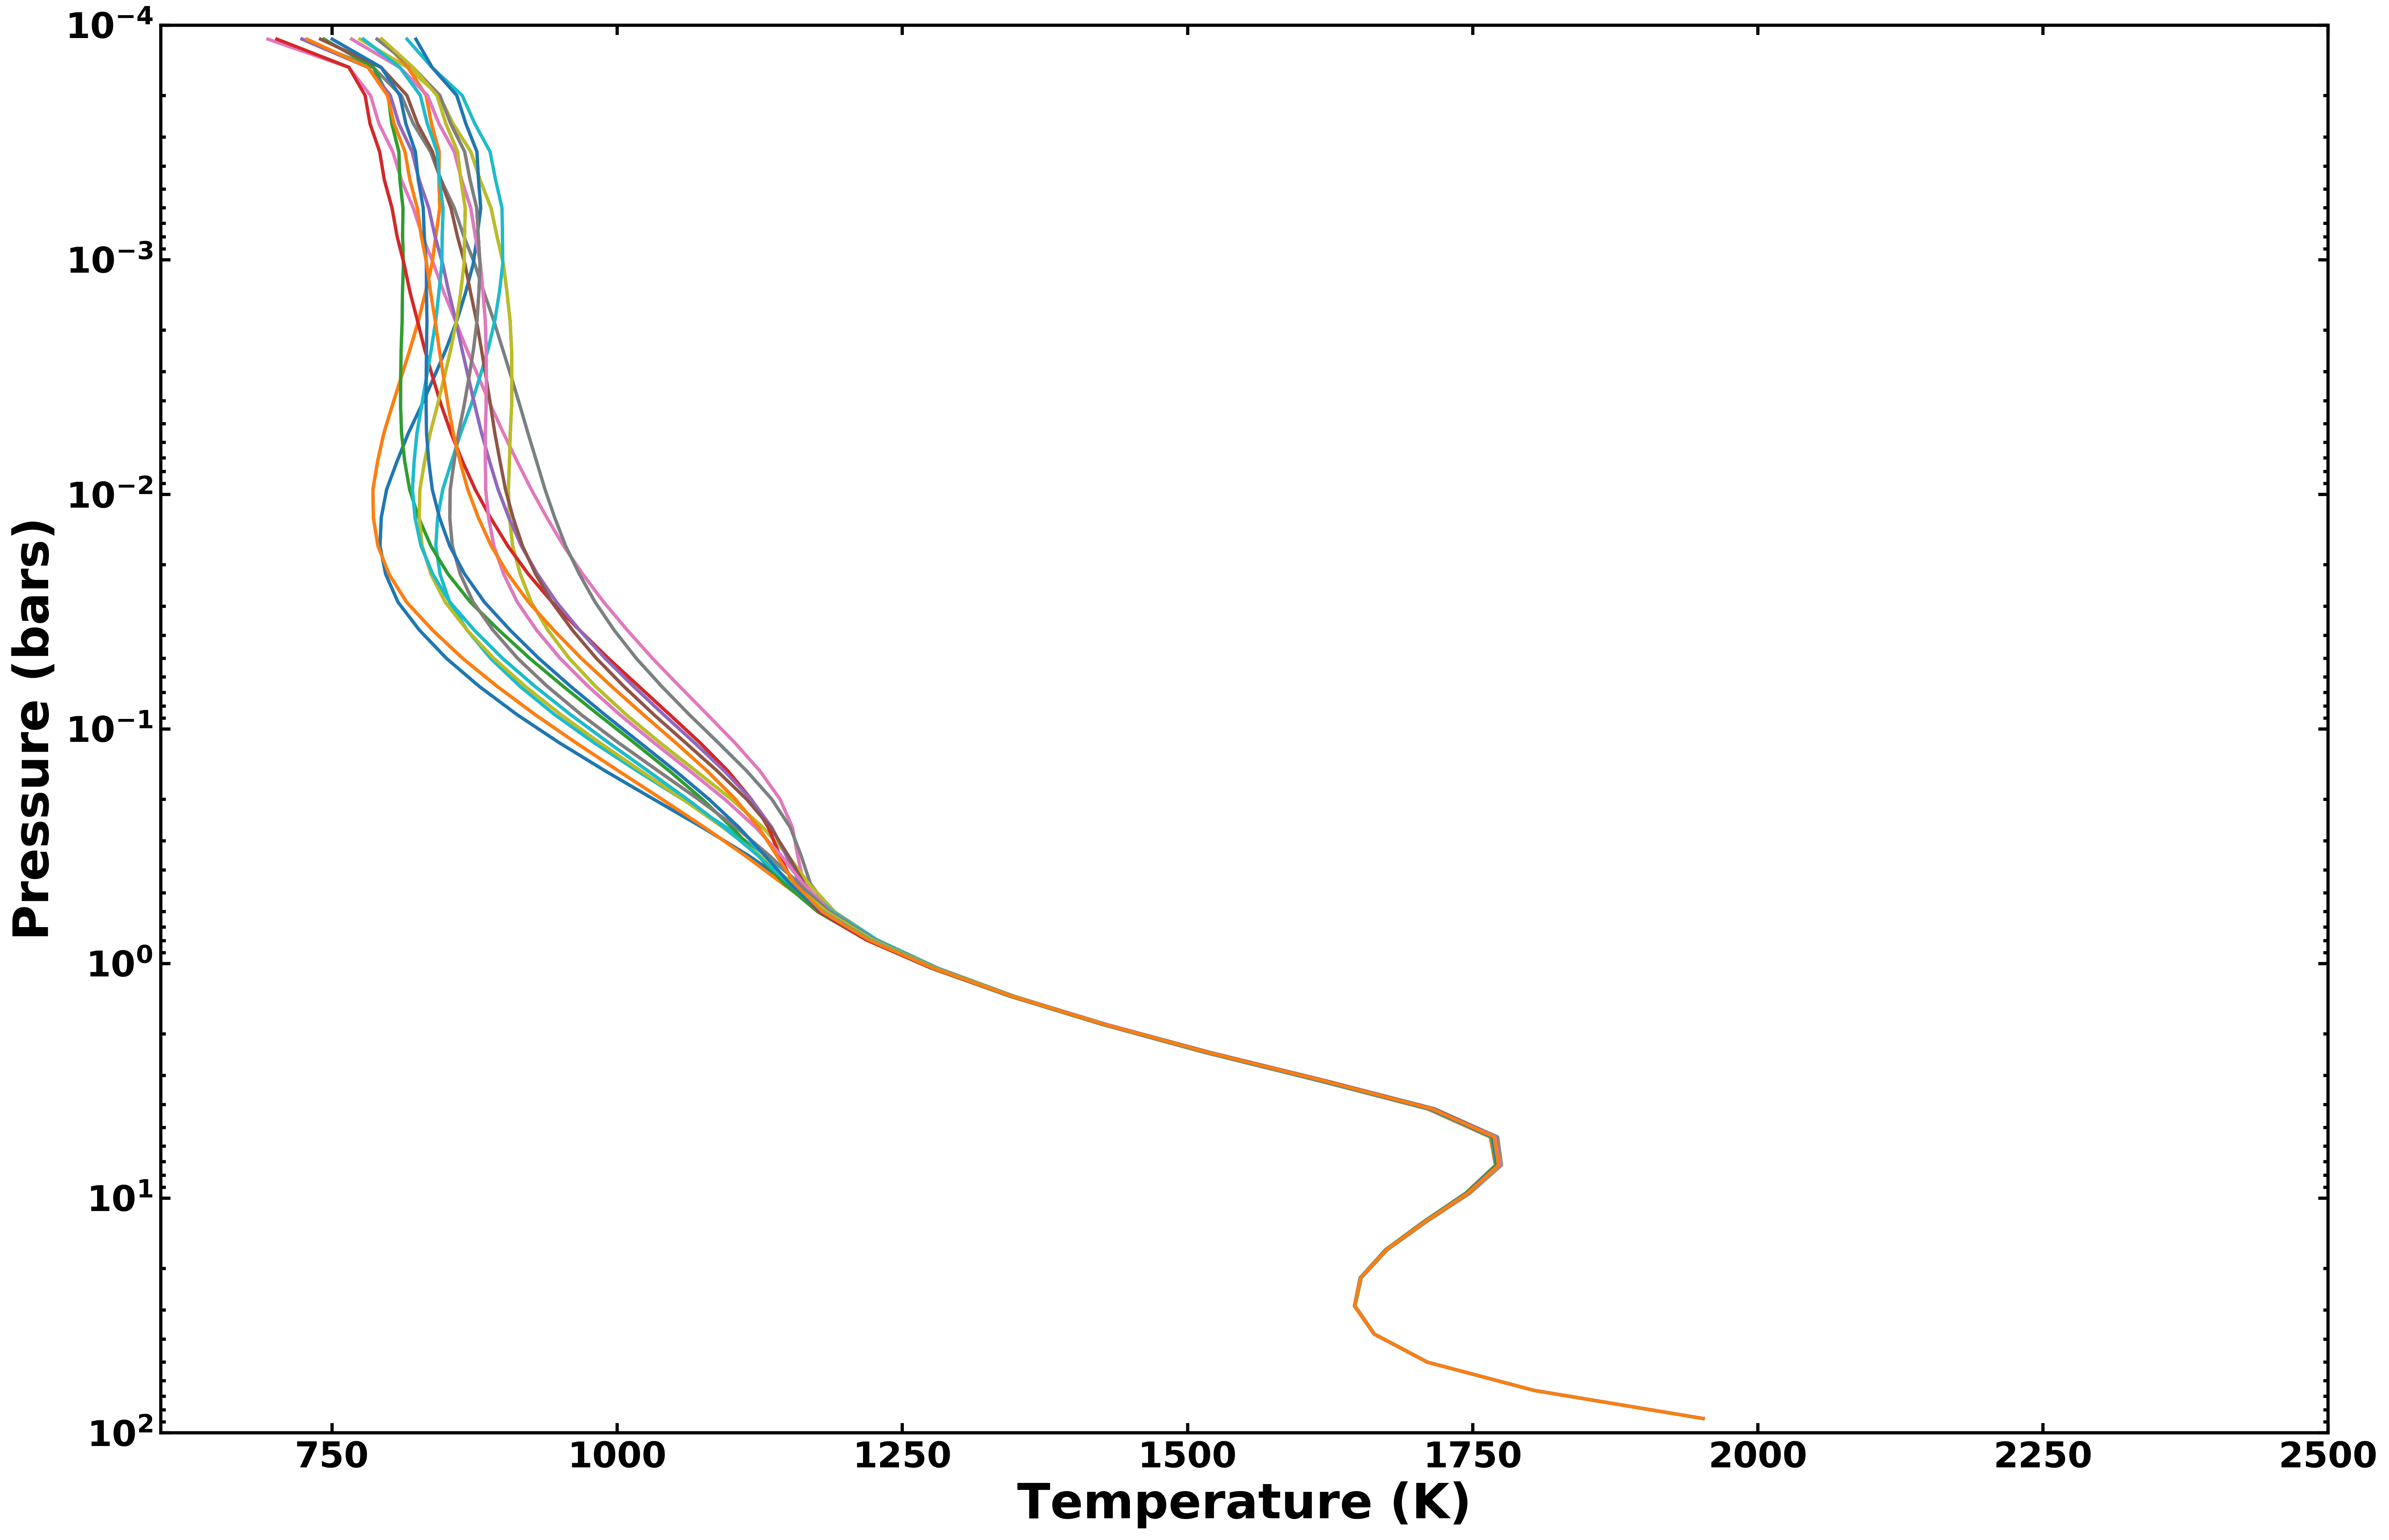

In [169]:
'''


Caleb K. Harada
charada@berkeley.edu


Map temperature inversions and show TP profiles (2 cases)


'''

### ----- INPUT/OUTPUT CONTROL ----- ###

cases = ['/home/imalsky/Desktop/test']


condensation_data = '/media/imalsky/Samsung_T5/Hot-Jup-Data/Condensation_Ts.dat'         # condensation curves
output_file = '/home/imalsky/Desktop/test-clouds.jpg'

fontsize = 24

Tmin = 0
Tmax = 1000

# file info
NLAT = 4
NLON = 8
NTAU = 50
NPARAMS_list = [12, 12, 12]


### ----- IMPORT LIBRARIES ----- ###

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams, rc
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.style.use('/home/imalsky/isaac-style.txt')


# set rcParams ~~~~~~~~~~~~~~~~~~~~~~~~
rcParams['axes.linewidth'] =    2
rcParams['xtick.major.size'] =  6
rcParams['xtick.major.width'] = 2
rcParams['xtick.minor.size'] =  3
rcParams['xtick.minor.width'] = 2
rcParams['ytick.major.size'] =  6
rcParams['ytick.major.width'] = 2
rcParams['ytick.minor.size'] =  3
rcParams['ytick.minor.width'] = 2
font = {'size' : fontsize, 'weight' : 'bold'}
rc('font', **font)


# set up figure
print('Creating plot...')
fig, axes = plt.subplots(1,1, figsize=(24,16))
plt.subplots_adjust(wspace=0.01, hspace=0.03)


for ind, case in enumerate(cases):

    ### ----- LOAD DATA FROM FILE ----- ###
    cloudreport = f'{case}.txt'
    NPARAMS = NPARAMS_list[ind]

    data = np.loadtxt(cloudreport, skiprows=0)
    

    # separate data into more convenient arrays
    data = data.reshape((NLAT, NLON, NTAU, NPARAMS))

    lons = data[:,:,0,1][0] - 180
    lats = data[:,:,0,0][:,0]
    

    ### ----- CALCULATE TEMP INVERSIONS FOR PLOTTING ----- ###

    # empty array to store values
    delta_temps = np.zeros((NLAT, NLON))
    taus = np.zeros((NLAT, NLON))



    # colormap
    cm_name = 'nuuk'
    cm_file = np.loadtxt(f'/home/imalsky/ScientificColourMaps7/{cm_name}/{cm_name}.txt')
    my_colors = mcolors.LinearSegmentedColormap.from_list(cm_name, cm_file)

    # plot all TP-profiles (expensive)
    for i in range(NLAT):
        for j in range(8):
            
            axes.semilogy(data[i][j][:,5], data[i][j][:,4], '-', lw=2)

    #axes.set_xlim([750, 3000])
    #axes.set_ylim([1e-4, 1e1])
    #axes.set_xlim([500, 2500])
    axes.invert_yaxis()


axes.set_xlabel('Temperature (K)', weight='bold')
axes.set_ylabel('Pressure (bars)', weight='bold')
axes.set_xlim(600, 2500)
axes.set_ylim(1e2, 1e-4)

fig.savefig(output_file, bbox_inches='tight', dpi=100)


